In [2]:
import numpy as np
import matplotlib.pyplot as plt

from counterfactualgp import simulation

In [3]:
rng = np.random.RandomState(0)

n_samples, n_train = 500, 300
avg_obs = 15
# Obs Time
low, high = 0.0, 24.0
prediction_times = [12.0]
time = prediction_times[0]
# Trajectory
ln_a, ln_l, noise_scale = 2.0 * np.log(0.2), np.log(8.0), 0.1
# Treatment
rx_win, rx_effect = 2.0, 1.0
policy1_params =  2.0, -0.5,    0.0  # History window, policy weight, policy bias
policy2_params =  2.0,  0.5,    0.0
policy3_params =  2.0,  1.0,    0.0
policy4_params =  2.0, -0.5,    0.0

In [4]:
obs_proc = simulation.ObservationTimes(low, high, avg_obs)

In [5]:
traj_linear = simulation.Trajectory(lambda x: x*1.1 + 2.5)

In [6]:
samples = [simulation.sample_trajectory(traj_linear, obs_proc, ln_a, ln_l, noise_scale, rng) for _ in range(n_samples)]

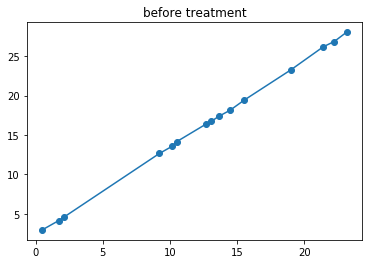

In [17]:
plt.plot(samples[0][1], samples[0][0], marker = 'o')
plt.title('before treatment')
plt.show()

In [8]:
policy1 = simulation.TreatmentPolicy(*policy1_params, rx_win, rx_effect)
policy2 = simulation.TreatmentPolicy(*policy2_params, rx_win, rx_effect)
policy3 = simulation.TreatmentPolicy(*policy3_params, rx_win, rx_effect)
policy4 = simulation.TreatmentPolicy(*policy4_params, rx_win, 0.0)  # Policy 1 with no effect.

In [13]:
train2 = simulation.treat_data_set(samples[:n_train], policy2, rng)

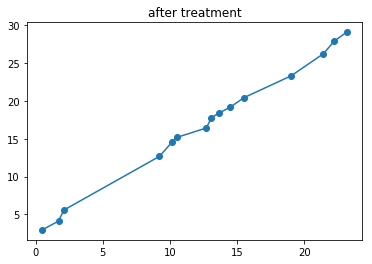

In [18]:
plt.plot(train2[0][1][0], train2[0][0], marker = 'o')
plt.title('after treatment')
plt.show()